## Notebook to tune XGB Model  File: 1

**This notebook predicts LOS Range given patient demographics, primay Diagnosis, Diagnosis category and comorbidities**

### Step 1: Import all necessary libraries

In [37]:
import pandas as pd
import numpy as np

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import *

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

### Step 2: Load the data file

In [38]:
rawdata = pd.read_csv('data/DiagVsLOSRangev3.csv', index_col=[0])

data = rawdata

### Step 3 Preprocess the data for the model 

In [39]:
#Drop text column DiagDesc 
data.drop(columns='DiagDesc', inplace=True)

#encode categorical columns
CatgCols = ['Gender', 'Ethinicity', 'Religion', 'MaritalStatus',
       'DiagnosisCategory', 'PrimaryDiag', 'DiagGroup']

le = preprocessing.LabelEncoder()
data = rawdata
data[CatgCols].values.flatten()
le.fit(data[CatgCols].values.flatten().astype(str))
data[CatgCols] = le.transform(data[CatgCols].values.flatten().astype(str)).reshape(data[CatgCols].shape)

# encode predictor variable
lep = preprocessing.LabelEncoder()
lep.fit(data.LosRange)
lep_dict = dict(zip(lep.classes_, lep.transform(lep.classes_)))
print(lep_dict)
data.LosRange = lep.transform(data.LosRange)


{'0:<7': 0, '1:8-14': 1, '2:15-30': 2, '3:31-60': 3, '4:61-120': 4, '5:121-180': 5, '6:180+': 6}


**Choose target and unused columns in the dataset**

In [40]:
## Ignore the first three columns (LosRange, EntitySys, TotalLOS and )
target='LosRange'
NonFeatureCols =['LosRange','EntitySys','TotalLos','DiagDesc']   # always include predictor
featureList = [x for x in data.columns if x not in NonFeatureCols]

### Step 4 Split Train and Test Data sets for validating the model

In [41]:
# Create matrices and dataframes for train/test
X = data[featureList]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
dtrain, dtest = train_test_split(data, test_size=0.25, random_state=42, shuffle=True)

my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = my_imputer.fit_transform(X_train)
X_test = my_imputer.transform(X_test)

### Define function to print summary for base model and cv model

In [42]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
def printPredictions(alg, X, y, featureList):
    # get soft probability predictions
    pred_probabilities = alg.predict_proba(X)
    #Choose class with the max probability as the prediction
    y_hat = np.asarray([np.argmax(line) for line in pred_probabilities])

    print("Accuracy: %.2f%%" % (accuracy_score(y, y_hat) * 100.0))
    print('Precision Score: %0.5f' % precision_score(y, y_hat, average='macro'))
    print('Recall: %0.5f'    % recall_score(y, y_hat, average='macro'))
    cfm = metrics.confusion_matrix(y, y_hat)
    print(cfm)
    if (featureList != ''):
        sorted_idx = alg.feature_importances_.argsort()
        plt.barh(np.array(featureList)[sorted_idx][-20:], alg.feature_importances_[sorted_idx][-20:])
        plt.xlabel("Xgboost Feature Importance")

In [48]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
def printResults(alg, X, y, featureList):
    # get soft probability predictions
    pred_probabilities = alg.predict_proba(X)
    #Choose class with the max probability as the prediction
    y_hat = np.asarray([np.argmax(line) for line in pred_probabilities])

    print('Score: %0.5f' % alg.score(y, y_hat))
    print("Accuracy: %.2f%%" % (accuracy_score(y, y_hat) * 100.0))
    print('Precision: %0.5f' % precision_score(y, y_hat, average='macro'))
    print('Recall: %0.5f'    % recall_score(y, y_hat, average='macro'))
    cfm = metrics.confusion_matrix(y, y_hat)
    print(cfm)
    sorted_idx = alg.feature_importances_.argsort()
    plt.barh(np.array(featureList)[sorted_idx][-20:], alg.feature_importances_[sorted_idx][-20:])
    plt.xlabel("Xgboost Feature Importance")

### Step 5 Build a baseline model with sklean API

**Run a simple classifier as baseline to see the defaults**

In [44]:
import xgboost as xgb
import time
from sklearn.model_selection import cross_val_score
# Fit the classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
#print 'xgboost cross validation score', cross_val_score(clf,self.x_data,self.y_data)
start_time = time.time()
clf.fit(X_train, y_train)
elapsed = time.time() - start_time
print('Model Fit Time %s' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))

Model Fit Time 00h:01m:58s


**Review the results of the model**

Score: 0.20992
Accuracy: 29.07%
Precision: 0.19607
Recall: 0.21514
[[237  23  35  17  22   3  40]
 [100  17  15  18  21   2  17]
 [ 96  17  20  18  29   1  31]
 [ 82  18  20  20  28   4  40]
 [ 89   8  10  18  19   3  48]
 [ 31   8   9  11  10   0  30]
 [ 76   9  10  15  31   2 144]]


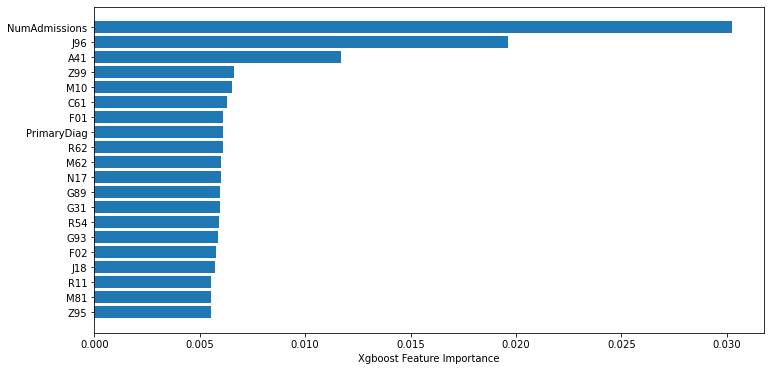

In [49]:
printResults(clf, X_test, y_test, featureList)

**Use function below for tuning the model**

In [50]:
def modelfit(alg, xtrain, ytrain, target, featureList,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(xtrain, label=ytrain, feature_names=featureList)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    #Fit the algorithm on the data
    alg.fit(xtrain, ytrain,eval_metric='merror')
    #Predict training set:
    dtrain_predictions = alg.predict(xtrain)
    dtrain_predprob = alg.predict_proba(xtrain)
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy  : %0.4f" % metrics.accuracy_score(ytrain, dtrain_predictions))
    print("Precision : %0.4f" % metrics.precision_score(ytrain, dtrain_predictions, average='macro'))
    print("Recall    : %0.4f" % metrics.recall_score(ytrain, dtrain_predictions, average='macro'))
    print("Balanced Accuracy  : %0.4f" % metrics.balanced_accuracy_score(ytrain, dtrain_predictions, adjusted=False))
    print("Precision(wtd) : %0.4f" % metrics.precision_score(ytrain, dtrain_predictions, average='weighted'))
    print("Recall(wtd)    : %0.4f" % metrics.recall_score(ytrain, dtrain_predictions, average='weighted'))
    print("Balanced Accuracy(adj)  : %0.4f" % metrics.balanced_accuracy_score(ytrain, dtrain_predictions, adjusted=True))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp[0:20].plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

**This function prints the model tree to the file**

In [62]:
def printModelStats(model, dtrain, dtest, featureList, target):
    # Print Training Predictions
    print("Training Predictions")
    printPredictions(model, dtrain[featureList], dtrain[target], featureList)
    # Print Test Predictions
    print("Test Predictions")
    printPredictions(model, dtest[featureList], dtest[target], featureList = '')
    print('Number of Trees %d' % len(model.get_booster().get_dump()))

def save_tree(xgb_model, filename, rankdir='UT'):
    """
    Plot the tree in high resolution
    :param xgb_model: xgboost trained model
    :param filename: the pdf file where this is saved
    :param rankdir: direction of the tree: default Top-Down (UT), accepts:'LR' for left-to-right tree
    :return:
    """
    import xgboost as xgb
    import os
    gvz = xgb.to_graphviz(xgb_model, num_trees=xgb_model.best_iteration, rankdir=rankdir)
    _, file_extension = os.path.splitext(filename)
    format = file_extension.strip('.').lower()
    data = gvz.pipe(format=format)
    full_filename = filename
    with open(full_filename, 'wb') as f:
        f.write(data)

**Model Tuning**

#### Fix learning rate and number of estimators for tuning tree-based parameters


Model Report
Accuracy  : 0.3934
Precision : 0.5798
Recall    : 0.2950
Balanced Accuracy  : 0.2950
Precision(wtd) : 0.5261
Recall(wtd)    : 0.3934
Balanced Accuracy(adj)  : 0.1775
Model Fit Time 00h:00m:18s


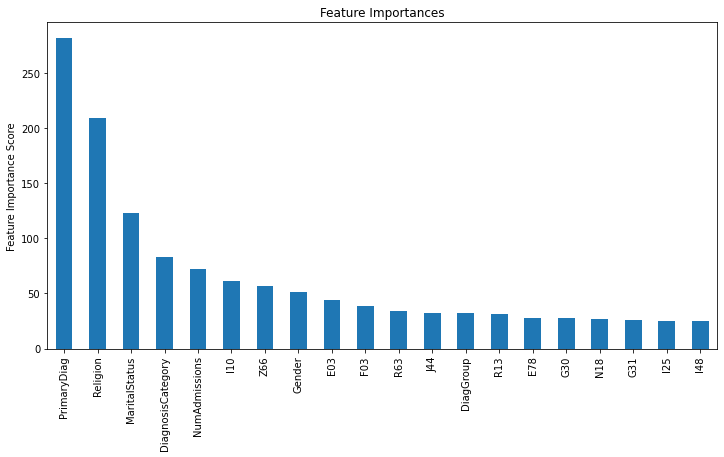

In [52]:
xgb1 = XGBClassifier(
 eval_metric='merror',
 learning_rate =0.2,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=2,    # can be more for balanced classes
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=8,
 num_class=7,
 use_label_encoder=False,
 seed=27)

start_time = time.time()
modelfit(xgb1, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, early_stopping_rounds=50)
elapsed = time.time() - start_time
print('Model Fit Time %s' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))

**Print Predictions**

Training Predictions
Accuracy: 39.34%
Precision Score: 0.57977
[[1002    6   10   11   14    1   97]
 [ 390   64    8    6   17    0   66]
 [ 428   11   80    8   12    0   97]
 [ 397    6   13   76   18    0  128]
 [ 320    5   10    7  111    1  150]
 [ 169    1    7    9    6   12   93]
 [ 300    4    9    8   17    0  510]]
Test Predictions
Accuracy: 30.28%
Precision Score: 0.23221
[[313   4   7  11  10   0  50]
 [155   1   8   8   8   0  34]
 [147   3  10   7  13   0  29]
 [121   5   8   2   7   0  53]
 [115   9   7   9  10   1  49]
 [ 59   1   4   3   5   1  33]
 [ 93   2   5   6   7   0 139]]


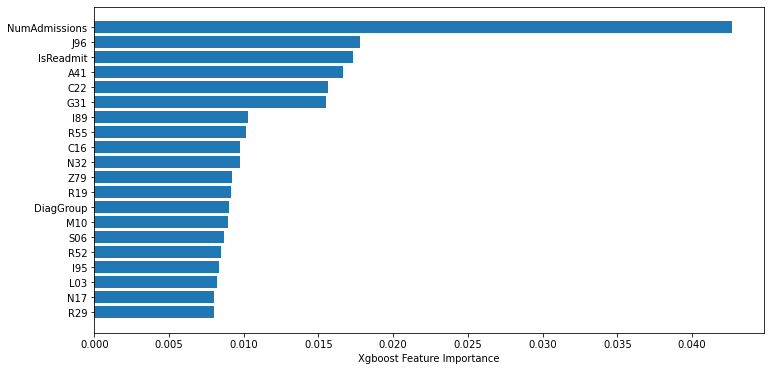

In [53]:
# Print Training Predictions
print("Training Predictions")
printPredictions(xgb1, dtrain[featureList], dtrain[target], featureList)
# Print Test Predictions
print("Test Predictions")
printPredictions(xgb1, dtest[featureList], dtest[target], featureList = '')

**Plot tree to explain the model**

In [54]:
print('Number of Trees %d' % len(xgb1.get_booster().get_dump()))

Number of Trees 133


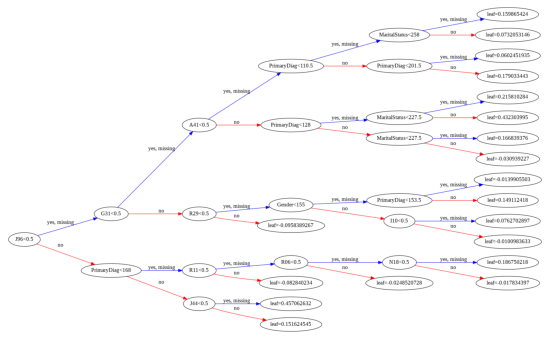

In [55]:
from xgboost import plot_tree
xgb.plot_tree(xgb1, rankdir='LR')
plt.show()

**Increase tree depth**


Model Report
Accuracy  : 0.7595
Precision : 0.8285
Recall    : 0.7159
Balanced Accuracy  : 0.7159
Precision(wtd) : 0.7951
Recall(wtd)    : 0.7595
Balanced Accuracy(adj)  : 0.6685
Model Fit Time 00h:00m:55s


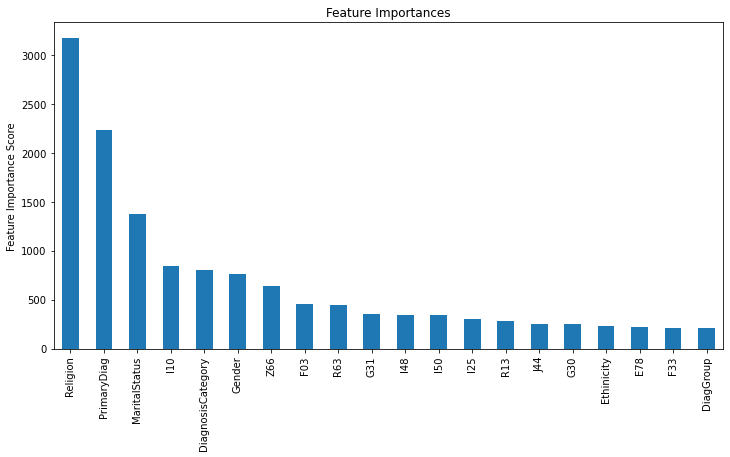

In [56]:
xgb2 = XGBClassifier(
 eval_metric='merror',
 learning_rate =0.2,
 n_estimators=1000,
 max_depth=15,
 min_child_weight=2,    # can be more for balanced classes
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=8,
 num_class=7,
 use_label_encoder=False,
 seed=27)

start_time = time.time()
modelfit(xgb2, dtrain[featureList], dtrain[target], target, featureList, useTrainCV=True, cv_folds=5, early_stopping_rounds=50)
elapsed = time.time() - start_time
print('Model Fit Time %s' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))

In [ ]:
printModelStats(xgb2, dtrain, dtest, featureList, target)

Training Predictions
Accuracy: 75.95%
Precision Score: 0.82848
[[1062    2   11   13    9    4   40]
 [ 121  346    9   10   16    2   47]
 [ 141    5  405   11   19    3   52]
 [ 117    8    6  444   14    3   46]
 [  90    5    7   15  419    4   64]
 [  46    6    5   11    9  164   56]
 [  82    2   10    6    7    0  741]]
Test Predictions
Accuracy: 28.44%
Precision Score: 0.19500
[[238  25  30  26  28   5  43]
 [109  15  27  14  13   3  33]
 [ 93  12  21  25  27   1  30]
 [ 84  11  16  16  19   3  47]
 [ 77  12  20  16  21   4  50]
 [ 41   4   8  11  11   1  30]
 [ 58   6   6  19  21   7 135]]
Number of Trees 203


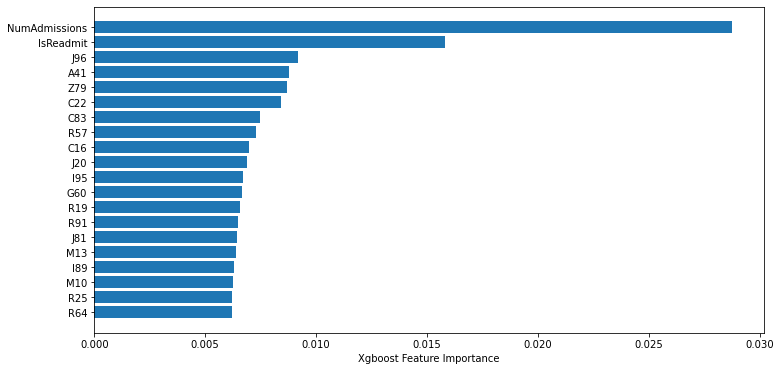

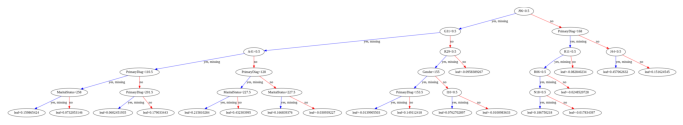

In [57]:
xgb.plot_tree(xgb2, rankdir='TR')
plt.show()

**Search for max_depth and min_child_weight**

In [58]:
param_test1 = {
 'max_depth':range(4,20,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV( estimator = XGBClassifier( eval_metric='merror',
                                                    learning_rate =0.2,
                                                    n_estimators=1000,
                                                    max_depth=15,
                                                    min_child_weight=2,    # can be more for balanced classes
                                                    gamma=0,
                                                    subsample=0.8,
                                                    colsample_bytree=0.8,
                                                    objective= 'multi:softprob',
                                                    nthread=8,
                                                    num_class=7,
                                                    use_label_encoder=False,
                                                    seed=27), 
                        param_grid = param_test1, 
                        scoring='roc_auc_ovr',
                        n_jobs=5, 
                        cv=5)
gsearch1.fit(dtrain[featureList],dtrain[target])


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8,
                                     enable_categorical=False,
                                     eval_metric='merror', gamma=0, gpu_id=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.2, max_delta_step=None,
                                     max_depth=15, min_child_weight=2,
                                     missing=nan...
                                     num_class=7, num_parallel_tree=None,
                                     objective='multi:softprob', predictor=None,
                                     random_state=None, reg_alpha=None,
                   

**Get parameters of the best model**

In [59]:
gsearch1.best_estimator_.get_xgb_params()

{'objective': 'multi:softprob',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.2,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 27,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'eval_metric': 'merror',
 'nthread': 8,
 'num_class': 7,
 'seed': 27}

**Use parameters from the best model**

Tweak a few other parameters for performance lik threads and parallel trees

[00:45:59] WARNING: ../src/learner.cc:576: 
Parameters: { "max_leaf_nodes" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:45:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=15
[00:46:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=15
[00:46:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=15
[00:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[00:46:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=15
[00:46:03] INFO: ../src/tree/updater_prune.cc:101: tree prun

[00:46:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[00:46:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:46:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[00:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[00:46:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[00:46:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=15
[00:46:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[00:46:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[00:46:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra n

[00:47:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[00:47:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 262 extra nodes, 0 pruned nodes, max_depth=15
[00:47:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=15
[00:47:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:47:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=15
[00:47:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=15
[00:47:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[00:47:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[00:47:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra n

[00:48:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[00:48:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=15
[00:48:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[00:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[00:48:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[00:48:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[00:48:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[00:48:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=15
[00:48:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra n

[00:49:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[00:49:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=15
[00:49:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[00:49:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[00:49:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[00:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=15
[00:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[00:49:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=15
[00:49:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra n

[00:50:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=15
[00:50:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=15
[00:50:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[00:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=15
[00:50:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[00:50:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=15
[00:50:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:50:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[00:50:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra no

[00:51:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[00:51:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=15
[00:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[00:51:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[00:51:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=15
[00:51:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=15
[00:51:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[00:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[00:51:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra n

[00:51:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:51:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[00:51:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=15
[00:51:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[00:51:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[00:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:51:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[00:52:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[00:52:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[00:52:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[00:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[00:52:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[00:52:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=15
[00:52:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=15
[00:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[00:52:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=15
[00:52:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[00:52:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra n

[00:53:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[00:53:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[00:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[00:53:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[00:53:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=15
[00:53:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 274 extra nodes, 0 pruned nodes, max_depth=15
[00:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[00:53:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[00:53:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra n

[00:54:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[00:54:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra nodes, 0 pruned nodes, max_depth=15
[00:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[00:54:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra no

[00:55:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=15
[00:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=15
[00:55:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[00:55:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[00:55:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[00:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[00:55:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[00:55:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[00:55:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra n

[00:56:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[00:56:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[00:56:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[00:56:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=15
[00:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[00:56:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[00:56:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[00:56:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[00:56:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra n

[00:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[00:57:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[00:57:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[00:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[00:57:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=15
[00:57:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=15
[00:57:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[00:57:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=15
[00:57:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra n

[00:58:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[00:58:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[00:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[00:58:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[00:58:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[00:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[00:58:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[00:58:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=15
[00:58:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[00:58:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=15
[00:59:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[00:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[00:59:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[00:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=15
[00:59:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[00:59:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=15
[00:59:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[00:59:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 230 extra no

[00:59:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[00:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[00:59:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=15
[00:59:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[00:59:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 84 extra nodes, 0 pruned nodes, max_depth=15
[00:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[00:59:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[00:59:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=15
[00:59:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra no

[01:00:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=15
[01:00:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[01:00:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[01:00:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[01:00:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[01:00:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=15
[01:00:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[01:00:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra no

[01:01:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=15
[01:01:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[01:01:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[01:01:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[01:01:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[01:01:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[01:01:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[01:01:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[01:01:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra n

[01:02:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[01:02:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[01:02:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[01:02:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[01:02:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=15
[01:02:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=15
[01:02:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[01:02:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:02:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra n

[01:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[01:03:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[01:03:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:03:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[01:03:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=15
[01:03:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[01:03:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 92 extra nodes, 0 pruned nodes, max_depth=15
[01:03:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:03:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra node

[01:04:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=15
[01:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[01:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[01:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[01:04:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=15
[01:04:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:04:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[01:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[01:04:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra node

[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:04:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[01:04:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[01:04:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[01:05:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[01:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[01:05:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=15
[01:05:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:05:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=15
[01:05:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[01:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=15
[01:05:43] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[01:05:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 252 extra nod

[01:06:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=15
[01:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:06:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:06:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=15
[01:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:06:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[01:06:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=15
[01:06:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[01:06:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra no

[01:07:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=15
[01:07:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=15
[01:07:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=15
[01:07:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[01:07:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:07:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 76 extra nodes, 0 pruned nodes, max_depth=15
[01:07:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[01:07:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[01:07:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nod

[01:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=15
[01:08:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[01:08:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[01:08:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:08:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[01:08:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[01:08:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[01:08:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra n

[01:09:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[01:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:09:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=15
[01:09:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:09:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[01:09:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=15
[01:09:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:09:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=15
[01:09:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra n

[01:09:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=14
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[01:09:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra no

[01:10:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[01:10:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[01:10:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:10:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[01:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:10:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=15
[01:10:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[01:10:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[01:10:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra no

[01:11:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[01:11:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=15
[01:11:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 96 extra nodes, 0 pruned nodes, max_depth=15
[01:11:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:11:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=15
[01:11:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[01:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[01:11:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[01:11:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra no

[01:12:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:12:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[01:12:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[01:12:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=15
[01:12:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=15
[01:12:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=15
[01:12:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:12:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra no

[01:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 346 extra nodes, 0 pruned nodes, max_depth=15
[01:13:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=15
[01:13:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=15
[01:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=15
[01:13:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[01:13:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:13:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[01:13:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=15
[01:13:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra no

[01:14:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:14:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:14:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[01:14:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:14:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[01:14:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=15
[01:14:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=15
[01:14:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[01:14:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra no

[01:14:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[01:14:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[01:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[01:14:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[01:14:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=15
[01:14:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=15
[01:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[01:14:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[01:14:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra n

[01:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[01:15:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra nodes, 0 pruned nodes, max_depth=15
[01:15:35] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=15
[01:15:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:15:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[01:15:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=15
[01:15:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=15
[01:15:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[01:15:40] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 272 extra n

[01:16:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[01:16:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=15
[01:16:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=15
[01:16:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[01:16:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:16:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[01:16:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[01:16:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra n

[01:17:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=15
[01:17:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[01:17:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:17:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[01:17:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[01:17:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=15
[01:17:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[01:17:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[01:17:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra no

[01:18:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[01:18:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:18:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[01:18:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:18:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[01:18:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=15
[01:18:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:18:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:18:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra no

[01:19:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=15
[01:19:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=15
[01:19:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:19:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[01:19:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=15
[01:19:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=14
[01:19:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=15
[01:19:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=15
[01:19:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra n

[01:19:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[01:19:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=15
[01:19:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra nodes, 0 pruned nodes, max_depth=15
[01:19:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=15
[01:19:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=15
[01:19:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=15
[01:19:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=15
[01:20:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 198 extra nodes, 0 pruned nodes, max_depth=15
[01:20:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra no

[01:20:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[01:20:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=15
[01:20:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 90 extra nodes, 0 pruned nodes, max_depth=15
[01:20:29] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[01:20:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[01:20:30] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[01:20:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=15
[01:20:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[01:20:33] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra node

[01:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:21:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:21:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[01:21:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=15
[01:21:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=15
[01:21:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=15
[01:21:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:21:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra n

[01:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[01:22:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=15
[01:22:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[01:22:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:22:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 64 extra nodes, 0 pruned nodes, max_depth=15
[01:22:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[01:22:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=15
[01:22:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 86 extra nodes, 0 pruned nodes, max_depth=15
[01:22:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nod

[01:23:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:23:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[01:23:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:23:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[01:23:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[01:23:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[01:23:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[01:23:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=15
[01:23:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra n

[01:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 104 extra nodes, 0 pruned nodes, max_depth=15
[01:23:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[01:23:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=15
[01:23:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=15
[01:23:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=15
[01:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[01:23:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[01:23:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=15
[01:24:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[01:24:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=15
[01:24:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=15
[01:24:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=15
[01:24:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 88 extra nodes, 0 pruned nodes, max_depth=15
[01:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[01:24:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=15
[01:24:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[01:24:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=15
[01:24:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 184 extra no

[01:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 218 extra nodes, 0 pruned nodes, max_depth=15
[01:25:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=15
[01:25:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[01:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=15
[01:25:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 138 extra nodes, 0 pruned nodes, max_depth=15
[01:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=15
[01:25:26] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=15
[01:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[01:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra n

[01:26:12] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=15
[01:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=15
[01:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=15
[01:26:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:26:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[01:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra nodes, 0 pruned nodes, max_depth=15
[01:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=15
[01:26:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=15
[01:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 118 extra no

[01:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=15
[01:27:06] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=15
[01:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 98 extra nodes, 0 pruned nodes, max_depth=15
[01:27:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=15
[01:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=15
[01:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 146 extra nodes, 0 pruned nodes, max_depth=15
[01:27:09] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 56 extra nodes, 0 pruned nodes, max_depth=15
[01:27:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=15
[01:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nod

[01:27:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=15
[01:27:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[01:27:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=15
[01:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[01:28:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[01:28:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[01:28:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:28:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[01:28:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra n

[01:28:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=15
[01:28:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=15
[01:28:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 144 extra nodes, 0 pruned nodes, max_depth=15
[01:28:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=15
[01:28:56] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra nodes, 0 pruned nodes, max_depth=15
[01:28:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 70 extra nodes, 0 pruned nodes, max_depth=15
[01:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=15
[01:28:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=15
[01:28:59] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra no

[01:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=15
[01:29:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 74 extra nodes, 0 pruned nodes, max_depth=15
[01:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=15
[01:29:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=15
[01:29:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=15
[01:29:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=15
[01:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 268 extra nodes, 0 pruned nodes, max_depth=15
[01:29:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=15
[01:29:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra no

[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 244 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 134 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 94 extra nodes, 0 pruned nodes, max_depth=15
[01:30:24] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra no

[01:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 128 extra nodes, 0 pruned nodes, max_depth=15
[01:30:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=15
[01:30:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=15
[01:30:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=15
[01:30:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=15
[01:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=15
[01:30:53] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=15
[01:30:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=15
[01:30:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 174 extra n

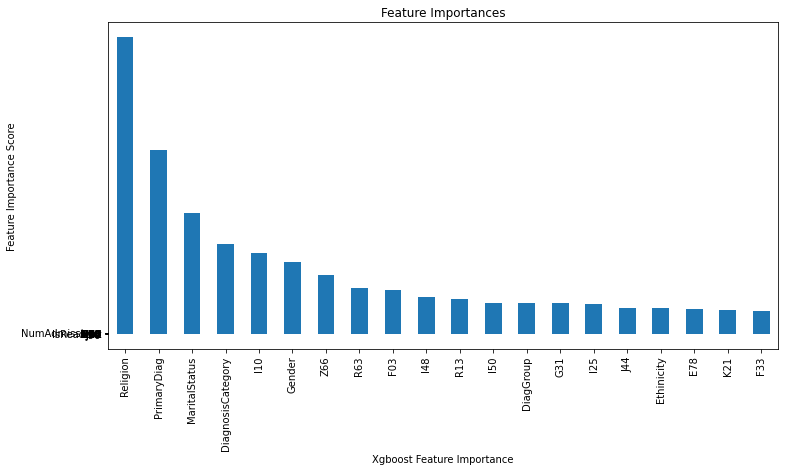

In [73]:
xgb3 = XGBClassifier(
    n_estimators=500,         # num_boosting_rounds passed to fit function
    num_class=7,               # number of multi class categories
    use_label_encoder=False,
    enable_categorical = False,   # only for gpu_hist tree methods

    # general parameters
    max_depth= 15,             # default=6 (3-10) lower  underfits
    learning_rate = 0.1,
    verbosity= 2,              # 0: silent 1: Info 2: Warn 3: debug

    booster= 'gbtree',
    #booster parameters
    min_child_weight= 1,       # default=1        higher underfits
    gamma= 0,                  # depends on loss function minimum loss needed to split set to regularize
    max_delta_step= 0,         # 0 is disabled, upper limit for wt neeeded to split the tree
    subsample= 0.6,            # sample observations for each tree 1 means all
    colsample_bytree= 0.8,     # cols to sample for each tree
    colsample_bylevel= 1,      # column sample at each level  Finer tuning to fix issues with data
    reg_lambda=1,              # L2 regularization evenly reduce of wts
    reg_alpha=0,               # L1 regularization eliminate weights randomly
    # learning parameters
    objective= 'multi:softprob',  # multi:softmax for classes  
    eval_metric= 'merror',
    seed= 27,                  # reproducible for parameter tuning. 
    tree_method= 'approx',     # based on column histograms rather than reading observations every time.

    base_score= 0.4,           # initial prediction score for all instances (global bias)
    missing = 0,               # when a value is missing assume 0
    random_state= 27,
    validate_parameters= 1,
)
start_time = time.time()
modelfit(xgb3, dtrain[featureList], dtrain[target], target, featureList, 
         useTrainCV=True, cv_folds=5, 
         early_stopping_rounds=50)
elapsed = time.time() - start_time
print('Model Fit Time %s' % time.strftime("%Hh:%Mm:%Ss", time.gmtime(elapsed)))
printModelStats(xgb3, dtrain, dtest, featureList, target)

Training Predictions
Accuracy: 71.90%
Precision Score: 0.81007
[[1051    4    6   14   12    0   54]
 [ 142  323   13   13   17    1   42]
 [ 134    7  408    8   17    1   61]
 [ 123    6   10  426   10    0   63]
 [ 115    5    7   16  387    1   73]
 [  71    6   11   19    9   99   82]
 [ 107    4   13   11   17    0  696]]
Test Predictions
Accuracy: 29.77%
Precision Score: 0.20301
[[261  12  37  26  19   2  38]
 [120  11  23  19  10   1  30]
 [101  15  19  16  21   2  35]
 [ 89  13  11  15  18   1  49]
 [ 76  12  10  10  21   3  68]
 [ 36   2  11  14   4   1  38]
 [ 63   4   7  17  19   2 140]]
Number of Trees 364


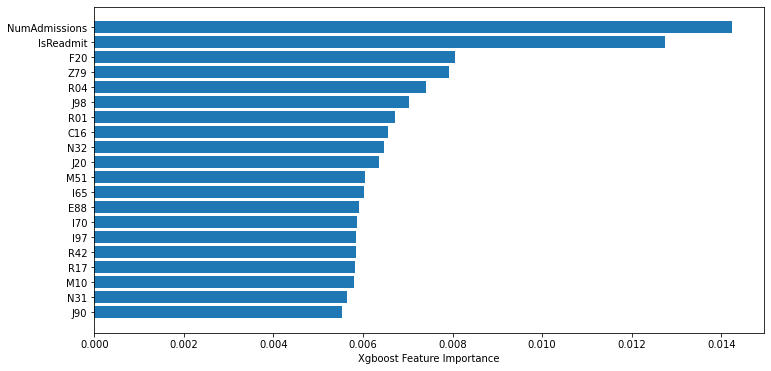

In [74]:
printModelStats(xgb3, dtrain, dtest, featureList, target)

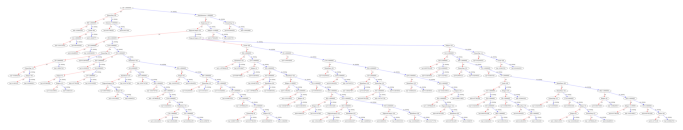

In [75]:
xgb.plot_tree(xgb3, rankdir='TR')
plt.show()